# Image Classification Model: CalTech 101 Dataset

This is a demonstration of how I created an image classification model using the fastai library. The dataset from CalTech in 2003 used in this incorporates images belonging to 101 different categories, with each including between 40-800 pictures. Through training, the model was able to obtain roughly 94% accuracy in recognizing over 9000 images and labeling them correctly out of the 101 possible categories.

Here are more details regarding the Caltech 101 dataset:
http://www.vision.caltech.edu/Image_Datasets/Caltech101/#Description

Here, I imported the necessary packages from the fastai library to allow me to create the model. Additionally, I imported the regex package in order to extract the labels from the Path objects.

In [1]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.widgets import *
import re

%reload_ext autoreload
%autoreload 2
%matplotlib inline

bs = 64

# Set-Up: Examining the Data

The fastai library provides many useful functions and methods, such as *untar_data* and *ls*. The *untar_data* function allows me to pass a URL from the fastai data directory and downloads and extracts the data into the path I specified. By doing so, the images downloaded to my local working directory and their location can be accessed as a Path object. The *ls* method works similarly to Unix OS ls command in which it lists all the computer files in the working directory.   

In [8]:
PATH1 = Path('/home/ubuntu/course-v3/nbs/dl1/data')
path = untar_data(URLs.CALTECH_101, dest=PATH1)
path.ls()

[PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/caltech_101/lotus'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/caltech_101/crayfish'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/caltech_101/rooster'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/caltech_101/tick'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/caltech_101/rhino'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/caltech_101/ferry'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/caltech_101/accordion'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/caltech_101/cup'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/caltech_101/ant'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/caltech_101/barrel'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/caltech_101/brontosaurus'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/caltech_101/hawksbill'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/caltech_101/scissors'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/caltech_101/crocodile'),
 PosixPath(

After using *untar_data* and *ls*, we can see that the paths listed are all the folders containing the images for each category. If we create anoter path specifying the category and use ls, all the images of that category are listed. I listed the first five for space, but there are 66 images for this specific category, Lotus.

In [15]:
lotus = path/'lotus'
print('There are ' + str(len(lotus.ls())) + ' images in the Lotus category')
lotus.ls()[:5]

There are 66 images in the Lotus category


[PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/caltech_101/lotus/image_0036.jpg'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/caltech_101/lotus/image_0057.jpg'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/caltech_101/lotus/image_0027.jpg'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/caltech_101/lotus/image_0021.jpg'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/caltech_101/lotus/image_0013.jpg')]

Here, I created a list to contain the Path objects for all the images that were used in the model. Through list comprehension, I accessed each category folder and retrieved the images through another helpful function, *get_image_files*, which took in the string format of the Path object. fnames contains over 9000 images so I listed the first five for space. 

In [27]:
fnames = []
fnames = [image for name in path.ls() for image in get_image_files(str(name))]
print('There are ' + str(len(fnames)) + ' images in the fnames list')
fnames[:5]

There are 9144 images in the fnames list


[PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/caltech_101/lotus/image_0036.jpg'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/caltech_101/lotus/image_0057.jpg'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/caltech_101/lotus/image_0027.jpg'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/caltech_101/lotus/image_0021.jpg'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/caltech_101/lotus/image_0013.jpg')]

Here is just a way of seeing the categories that are in the dataset in a list. The first five are listed for space.

In [69]:
path_names = [str(name) for name in path.ls()]
path_names

annotations = r'\/([\w]+$)'
p = re.compile(annotations)
clean_names = [p.findall(name) for name in path_names]
real_names = [clean_names[i][0] for i in range(len(clean_names)) if len(clean_names[i])]
real_names[:5]

['lotus', 'crayfish', 'rooster', 'tick', 'rhino']

After observing all the image data Path objects, I noticed a pattern amongst them all.

- PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/caltech_101/**lotus**/image_0036.jpg')

- PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/caltech_101/**tick**/image_0047.jpg')

- PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/caltech_101/**accordion**/image_0032.jpg')

The categories were listed within the filenames themselves. First, I implemented a regular expression code snippet which cut out the category from the filename. Using the fastai library, I utilized a function *ImageDataBunch.from_name_re* which was specifically made to extract the categories from the filename and label the images by using my regex code, creating an ImageDataBunch object of fastai library which allows me to access the data and use it for the model.  

In [28]:
np.random.seed(2)
pat = r'101\/([^\/]+)\/image'

In [29]:
data = ImageDataBunch.from_name_re(path, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

Here is the data that we are working with. There are various methods and instance variables that come with an ImageDataBunch object such as *show_batch* and *classes*.

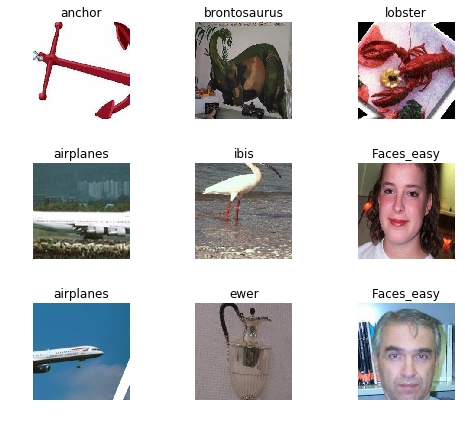

In [32]:
data.show_batch(rows=3, figsize=(7,6))

In [34]:
print(data.classes)
len(data.classes),data.c

['BACKGROUND_Google', 'Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy', 's

(102, 102)

# Image Classifcation Model: Creating & Training

Now, I am using the fastai learner model which takes in an image as an input and predicts the category that it belongs to, listing the probability of each category. The learner uses the data as an *ImageDataBunch* object and the model we are using, resnet34, as arguments to create itself.

In [37]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

By calling the *fit_one_cycle* method, I am fitting the model in a more efficient and accurate manner. When the data ImageDataBunch object was created, a validation set was created inadvertently in order to prevent overfitting. We want the model to be able to predict the image's category based on the content not because it recognizes the image in general. By running through the dataset four times given the argument, it improves the model's ability to predict but not so much where overfitting becomes an issue. The error rate metric indicates the accuracy of the model through each interval.

In [38]:
learn.fit_one_cycle(4)

Given these results, I saved the weights generated from this run with the *save* method in order to be more efficient and not spend more time running the same line of code above. Our model was roughly 93% accurate (7.16% error rate).

In [181]:
learn.save('stage-1')

# Intepretating the Results

Given the model results, I wanted to see what were the categories that got confused often in order to see if the model was reasonable in choosing the wrong category. When plotting the top losses, I noticed that many of which were confused with *BACKGROUND_GOOGLE*, a category created by CalTech as a clutter category. The losses indicate the confidence the model made the incorrect prediction with, which is reasonable to confuse with BACKGROUND_GOOGLE given it was a random category of images with no real theme other than to clutter.

In [39]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

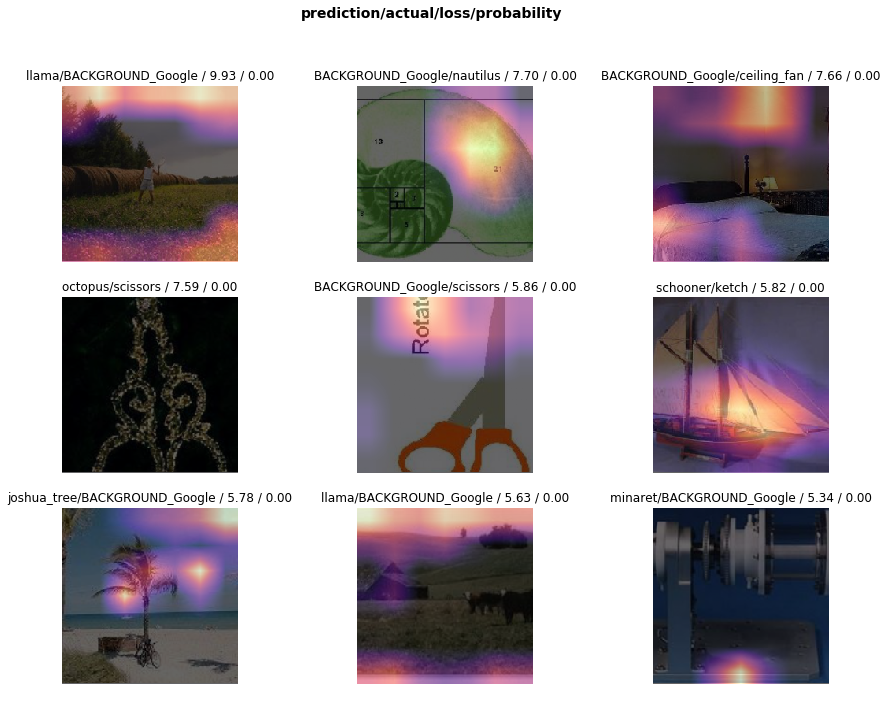

In [43]:
interp.plot_top_losses(9, figsize=(15,11))

Another way of looking at the results is through a confusion matrix, although there are many categories that compress the matrix, making it hard to read. Essentially, it lists how many times that there was a category and it was able to match it with that correct category and if not with a different category. The larger the number, the darker the square and we can observe the linearity of the matrix, indicating that the model was accurately predicting the category, with only a few incorrect predictions lying out of that line.  

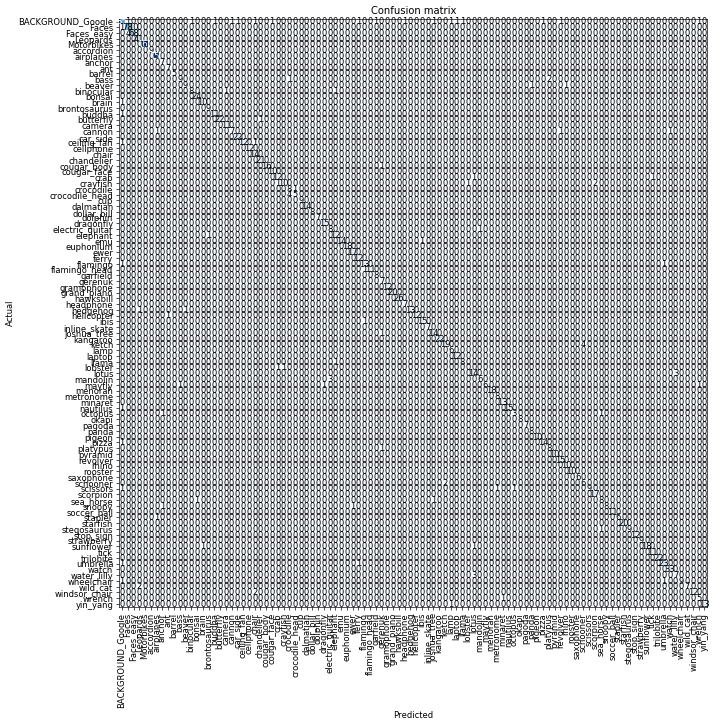

In [185]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Finally, we can see what categories were confused with each other the most, essentially bringing out those numbers outside of the linearity of the confusion matrix. Looking at the categories, it is very reasonable for the model and even a person to mistake the images. Categories such as water lily to lotus or ketch to schooner are difficult to distinguish but the model was able to do so at a 94% accuracy even when given 101 categories ranging over 9000 images. Those errors with the aforementioned categories only occurred 11 times. 

In [41]:
interp.most_confused(min_val=2)

[('Faces', 'Faces_easy', 13),
 ('ketch', 'schooner', 6),
 ('Faces_easy', 'Faces', 5),
 ('lotus', 'water_lilly', 4),
 ('crayfish', 'lobster', 3),
 ('crocodile_head', 'crocodile', 3),
 ('water_lilly', 'lotus', 3),
 ('wild_cat', 'Leopards', 3),
 ('BACKGROUND_Google', 'chair', 2),
 ('BACKGROUND_Google', 'electric_guitar', 2),
 ('BACKGROUND_Google', 'llama', 2),
 ('bass', 'platypus', 2),
 ('emu', 'llama', 2),
 ('schooner', 'ketch', 2)]

# Fine-Tuning the Model: Unfreezing

Before when we trained the model using the one fit cycle method, we were only training the last few layers of the convulation model, as it is already a pre-trained model on ImageNet data with many layers. However, I want to train the whole model instead of the few end layers in order to better predict categories.

In [46]:
learn.unfreeze()

In [45]:
learn.fit_one_cycle(1)

The model got worse when I decided to train the whole model and all its layers instead of the last few layers. This is because it is training each layer equally, from the blunt lines and shapes to the extreme specificities. The pre-trained model based on the ImageNet data focused on each layer and did not rush through it all, which is why our previous model was more accurate. By using the *load* method, I can restore the original model.

In [47]:
learn.load('stage-1');

I decided to use the learning rate finder, which indicates the fastest I can train the model without it not working as effectively. It seems that once the learning rate passed 1e-06, the loss got worse, so I decided to splice the learning rate between 1e-07 and 1e-06 amongst the layers to minimize loss.

In [48]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


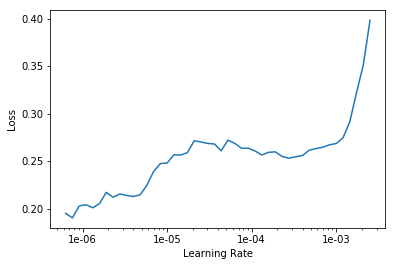

In [191]:
learn.recorder.plot()

In [49]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-7,1e-6))

The model is now roughly 94% accurate (6.1% error rate), which is a slight improvement from what we originally had.

# Image Classification Model: Production

Now, I want to export my model so that I can test it with images to see if it can accurately predict what the image is. Here was one of the images from the chair category in the dataset and we can use the model to predict what it is.

In [50]:
defaults.device = torch.device('cpu')
learn.export()

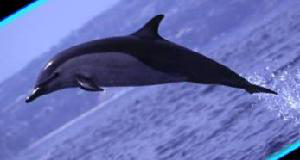

In [56]:
img = open_image(path/'dolphin'/'image_0018.jpg')
img

I now create and load the learner into my production environment and use the *predict* method of the Learner object to take in the image as an argument and predict its category.

In [57]:
learn = load_learner(path)

In [58]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category dolphin

I wanted to use a personal image instead of the ones from the dataset, so I took a picture of the chair I was sitting in as I created this project. I ran it through the model and sure enough, it was able to recognize it.

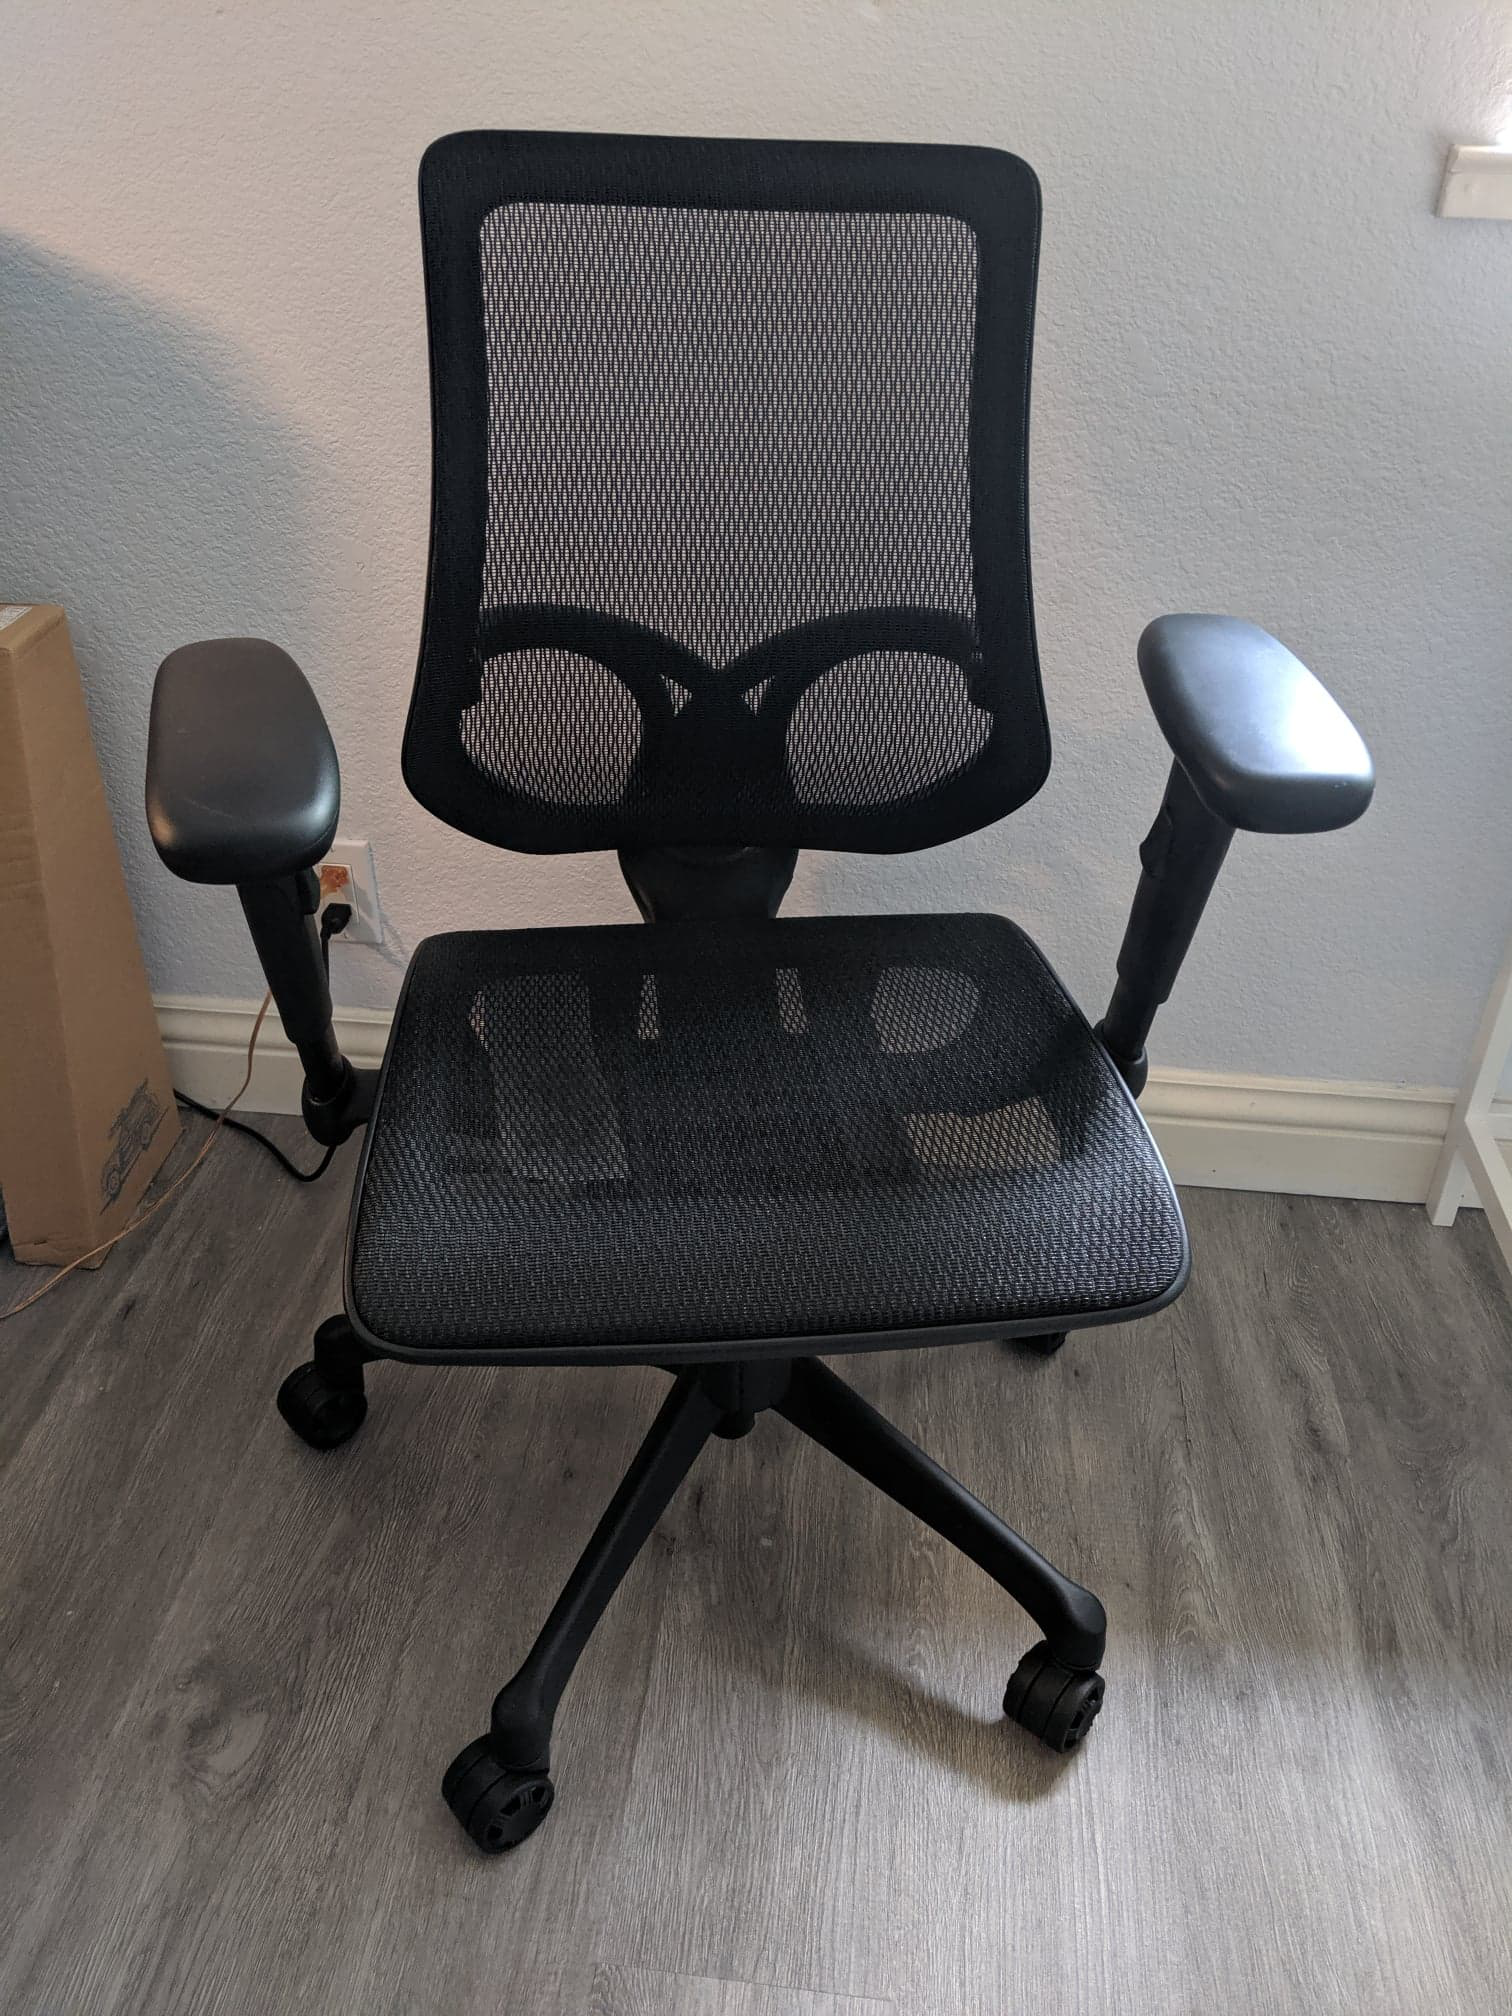

In [60]:
img = open_image(path/'chair'/'mychair.jpg')
img

In [61]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category chair

Now, I have a fast and accurate image recognition model trained on the Caltech 101 Image dataset. It can not only accurately recognize the images in the dataset and predict the category, it takes in any image related to those categories and can predict what it is with a 94% accuracy. 

Here is the reference for the dataset used in this notebook.

________________________________________________________________________________________________________________________________

L. Fei-Fei, R. Fergus and P. Perona. Learning generative visual models
from few training examples: an incremental Bayesian approach tested on
101 object categories. IEEE. CVPR 2004, Workshop on Generative-Model
Based Vision. 2004

L. Fei-Fei, R. Fergus and P. Perona. One-Shot learning of object
categories. IEEE Trans. Pattern Recognition and Machine Intelligence. In
press.